In [1]:
from copy import deepcopy
from pathlib import Path
import pickle
import json
import sys
from typing import Literal

from gears import PertData
import seaborn as sns
from sklearn.linear_model import ElasticNet
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

sys.path.insert(0, "../")
from scgpt.utils import compute_perturbation_metrics, filt_self_from_de

/home/users/geroldcsendes/miniconda3/envs/scgpt_yml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open("gene_name_map.json") as f:
    GENE_NAME_MAP = json.load(f)

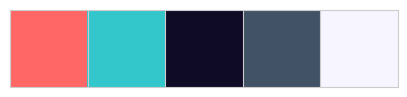

In [3]:
sns.set_style("whitegrid")
colors = ['#FF6666', '#33C7CC', '#0F0A26', '#425266', '#F7F5FF']
sns.set_palette(sns.color_palette(colors))
sns.palplot(sns.color_palette(colors))

In [4]:
def _get_go_features(is_norman: bool, perturbation_list: list, go_pca: pd.DataFrame):

    GO_NULL_STR = "NULL"
    go_pca = go_pca.copy()
    pert_list = [i.replace("ctrl+", "").replace("+ctrl", "") for i in perturbation_list]
    if is_norman:
        # insert NULL as a row to the go_pca with 0 values
        go_pca.loc[GO_NULL_STR] = 0

        pert1 = []
        pert2 = []
        for i in pert_list:
            if '+' in i:
                p1, p2 = i.split('+')
                pert1.append(p1)
                pert2.append(p2)
            else:
                pert1.append(i)
                pert2.append('NULL')
        
        go_features = go_pca.loc[pert1].values + go_pca.loc[pert2].values

    else:

        go_features = go_pca.loc[pert_list]
    return go_features

def create_bulk_data(
    pert_data: PertData, go_pca_: pd.DataFrame, is_norman: bool):

    data_splits = deepcopy(pert_data.set2conditions)

    train_samples = data_splits['train']
    val_samples = data_splits['val']
    
    train_samples.remove('ctrl')
    if 'ctrl' in val_samples:
        val_samples.remove('ctrl')
    
    test_samples = data_splits['test']

    assert 'ctrl' not in test_samples, "ctrl in test samples"

    data = pert_data.adata.to_df()
    data['condition'] = pert_data.adata.obs['condition']
    data = data.groupby('condition').mean()

    train_x = _get_go_features(is_norman, train_samples, go_pca_)
    train_y = data.loc[train_samples].copy()

    val_x = _get_go_features(is_norman, val_samples, go_pca_)
    val_y = data.loc[val_samples].copy()

    test_x = _get_go_features(is_norman, test_samples, go_pca_)
    test_y = data.loc[test_samples].copy()
    ctrl_mean = data.loc['ctrl'].values

    assert train_x.shape[0] == train_y.shape[0], "Train shapes do not match"
    assert test_x.shape[0] == test_y.shape[0], "Test shapes do not match"
    assert train_x.shape[1] == test_x.shape[1], "Train and test features do not match"
    assert train_y.shape[1] == test_y.shape[1], "Train and test targets do not match"
    assert ctrl_mean.shape[0] == train_y.shape[1] == test_y.shape[1], "ctrl mean shape does not match"
    assert ctrl_mean.ndim == 1, "ctrl mean is not 1D"

    print("Number of training samples: ", train_x.shape[0])
    print("Number of test samples: ", test_x.shape[0])

    return dict(
        train_x=train_x,
        train_y=train_y,
        val_x=val_x,
        val_y=val_y,
        test_x=test_x,
        test_y=test_y,
        ctrl_mean=ctrl_mean,
    )

def hp_search(
        model_class, hp_settings: list[dict], data, pert_data, key_pattern: str, is_norman: bool, out_dir: Path):
    
    _res = dict() 
    for _hp in hp_settings:
        _model_hp_id = [f"{k}={v}" for k, v in _hp.items()]
        _model_hp_id = "_".join(_model_hp_id)

        _model = model_class(**_hp)

        _model.fit(data['train_x'], data['train_y'])
        _pred = _model.predict(data['val_x'])

        valres = {
            "pert_cat": data['val_y'].index,
            "pred": _pred,
            "truth": data['val_y'].values,
        }
        _eval = compute_perturbation_metrics(
            results=valres,
            ctrl_adata=pert_data.adata[pert_data.adata.obs["condition"] == "ctrl"],
        )
        print(f"HP: {_model_hp_id}")
        print(f"Validation results: {_eval}")
        print("=" * 20)
        
        _res[_model_hp_id] = dict(
            model=_model,
            eval=_eval,
        )
    # pick the best based on pearson_delta
    best_n_est = max(_res, key=lambda x: _res[x]['eval']['pearson_delta'])

    # inference on test
    _model = _res[best_n_est]['model']
    _pred = _model.predict(data['test_x'])
    
    testres = {
        "pert_cat": data['test_y'].index,
        "pred": _pred,
        "truth": data['test_y'].values,
    }
    _eval = compute_perturbation_metrics(
        results=testres,
        ctrl_adata=pert_data.adata[pert_data.adata.obs["condition"] == "ctrl"],
    )
    de_dict_noself = filt_self_from_de(pert_data, is_norman)
    ctrl_data_noself = pert_data.adata[pert_data.adata.obs["condition"] == "ctrl"].copy()
    ctrl_data_noself.uns["rank_genes_groups_cov_all"] = de_dict_noself
    test_metrics_de20_noself = compute_perturbation_metrics(
        testres, ctrl_data_noself
    )["pearson_de_delta"]

    _eval["pearson_delta_de_no_knockout"] = test_metrics_de20_noself

    print(f"Best n_estimator: {_model_hp_id}")
    print(f"Test results: {_eval}")

    with open(out_dir / "test_metrics.json", "w") as f:
        json.dump(_eval, f)


    # persist best predictor
    _pred_df = pd.DataFrame(_pred, index=data['test_y'].index, columns=data['test_y'].columns)
    _pred_df.to_csv(out_dir / "predictions.csv")

    bulk_res = {
        "pert_cat": data['test_y'].index,
        "pred": _pred,
        "truth": data['test_y'].values,
    }
    np.savez(out_dir / "test_res_best_model.npz", **bulk_res)

    return _eval

def plot_results(df):
    fig, axs = plt.subplots(1, 1, figsize=(5, 5))

    palette = {k:v for k, v in zip(["scgpt", "mean", "rf", "en"], ['#FF6666', '#33C7CC', '#0F0A26', '#425266'])}
    sns.barplot(x='model', y='pearson_delta', data=df, ax=axs, hue='model', palette=palette)

    axs.set_title(f"Pearson Delta Results")

    plt.tight_layout()
    plt.show()


def run_models_on_dataset(
        _exp_ds_map: dict,
        _pert_data: PertData,
        _rs: int,
        _ds_name: Literal["adamson", "norman", "replogle", "replogle_rpe1"],
        _key_pattern: str,
        _res_out_dir_base: Path,

):
    _res_out_dir = _res_out_dir_base / _ds_name
    for _exp, _ds in _exp_ds_map.items():
        # random forest
        _res_dir_model = _res_out_dir / "RF" / _exp
        _res_dir_model.mkdir(parents=True, exist_ok=True)
        _res_out = hp_search(
            model_class=RandomForestRegressor,
            hp_settings=[
                dict(n_estimators=100, n_jobs=-1, random_state=_rs, verbose=True),
                dict(n_estimators=300, n_jobs=-1, random_state=_rs, verbose=True),
            ],
            data=_ds,
            pert_data=_pert_data,
            key_pattern=_key_pattern,
            is_norman=_ds_name == "norman",
            out_dir=_res_dir_model,
        )
        # elastic net
        _res_dir_model = _res_out_dir / "EN" / _exp
        _res_dir_model.mkdir(parents=True, exist_ok=True)
        _res_out = hp_search(
            model_class=ElasticNet,
            hp_settings=[
                dict(alpha=0.1, l1_ratio=0.5, random_state=_rs),
                dict(alpha=0.01, l1_ratio=0.5, random_state=_rs),
            ],
            data=_ds,
            pert_data=_pert_data,
            key_pattern=_key_pattern,
            is_norman=_ds_name == "norman",
            out_dir=_res_dir_model,
        )
        # knn regressor
        _res_dir_model = _res_out_dir / "KNN" / _exp
        _res_dir_model.mkdir(parents=True, exist_ok=True)
        _res_out = hp_search(
            model_class=KNeighborsRegressor,
            hp_settings=[
                dict(n_neighbors=1, n_jobs=-1),
                dict(n_neighbors=2, n_jobs=-1),
                dict(n_neighbors=5, n_jobs=-1),
            ],
            data=_ds,
            pert_data=_pert_data,
            key_pattern=_key_pattern,
            is_norman=_ds_name == "norman",
            out_dir=_res_dir_model,
        )

    # mean: does not depend on features
    mean_pred = _ds["train_y"].mean().values.reshape(1, -1)
    mean_pred = np.repeat(mean_pred, _ds["test_y"].shape[0], axis=0)

    testres = {
        "pert_cat": _ds['test_y'].index,
        "pred": mean_pred,
        "truth": _ds['test_y'].values,
    }
    res_mean = compute_perturbation_metrics(
        results=testres,
        ctrl_adata=_pert_data.adata[_pert_data.adata.obs["condition"] == "ctrl"],
    )
    de_dict_noself = filt_self_from_de(_pert_data, _ds_name == "norman")
    ctrl_data_noself = _pert_data.adata[_pert_data.adata.obs["condition"] == "ctrl"].copy()
    ctrl_data_noself.uns["rank_genes_groups_cov_all"] = de_dict_noself
    test_metrics_de20_noself = compute_perturbation_metrics(
        testres, ctrl_data_noself
    )["pearson_de_delta"]

    res_mean["pearson_delta_de_no_knockout"] = test_metrics_de20_noself

    _res_dir_model = _res_out_dir / "mean"
    _res_dir_model.mkdir(parents=True, exist_ok=True)
    with open(_res_dir_model / "test_metrics.json", "w") as f:
        json.dump(res_mean, f)
    
    pred_df = pd.DataFrame(mean_pred, index=_ds["test_y"].index, columns=_ds["test_y"].columns)
    pred_df.to_csv(_res_dir_model / "predictions.csv")

    bulk_res = {
        "pert_cat": _ds['test_y'].index,
        "pred": mean_pred,
        "truth": _ds['test_y'].values,
    }
    np.savez(_res_dir_model / "test_res_best_model.npz", **bulk_res)


def load_bulk_model_resutlts( dataset: str, _res_dir: Path = Path("./save")):
    
    feature_name_map = {
        "go": "go",
        "elmo": "scElmo",
        "foundation": "scFoundation",
        "gpt": "scGPT",
    }
    res_dict = {}
    for model in ["RF", "EN", "KNN"]:
        for feature in ["go", "elmo", "foundation", "gpt"]:
            with open(_res_dir / dataset / model / feature / "test_metrics.json") as f:
                res_dict[f"{model}_{feature_name_map[feature]}"] = json.load(f)
    with open(_res_dir / dataset / "mean" / "test_metrics.json") as f:
        res_dict["mean"] = json.load(f)

    return res_dict


def df_pca_transform(df, n_components=256):
    pca = PCA(n_components=n_components)
    pca_trafo = pca.fit_transform(df)
    pca_df = pd.DataFrame(pca_trafo, index=df.index)
    return pca_df


def model_eval_plots(df: pd.DataFrame, ds: str, out_dir: Path):
    
    first_models = ["scGPT", "scFoundation", "mean", "RF_go"]
    second_models = ["RF_go", "RF_scElmo", "RF_scFoundation", "RF_scGPT"]

    myfirst = df[df['model'].isin(first_models)]
    mysecond = df[df['model'].isin(second_models)]

    sns.barplot(x='model', y='pearson_delta', data=myfirst, order=first_models, color="#33C7CC")
    plt.title(ds)
    plt.xlabel("")

    plt.savefig(out_dir / f"{ds}_first_models.png", dpi=300, bbox_inches='tight')
    plt.savefig(out_dir / f"{ds}_first_models.pdf")
    plt.show()

    sns.barplot(x='model', y='pearson_delta', data=mysecond, order=second_models, color="#33C7CC")
    plt.title(ds)
    plt.xlabel("")

    plt.savefig(out_dir / f"{ds}_second_models.png", dpi=300, bbox_inches='tight')
    plt.savefig(out_dir / f"{ds}_second_models.pdf")
    plt.show()

    return

In [5]:
RANDOM_STATE = 42

RES_DIR = Path("./save")

In [6]:
go = pd.read_csv("../data/go/go_raw_matched.csv", index_col=0)
go = df_pca_transform(go, n_components=256)

sc_elmo = pd.read_parquet("../data/scElmo/ensem_emb_gpt3.5all_new.parquet")
sc_elmo = df_pca_transform(sc_elmo, n_components=256)

sc_foundation = pd.read_parquet("../data/scFoundation_embeds/embeddings.parquet")
sc_foundation = df_pca_transform(sc_foundation, n_components=256)

sc_gpt = pd.read_parquet("../data/scgpt_embeds/embeddings.parquet")
sc_gpt = df_pca_transform(sc_gpt, n_components=256)

## Adamson

In [7]:
pert_data_adamson = PertData("../data/")
pert_data_adamson.load(data_name='adamson')
pert_data_adamson.prepare_split(split="simulation", seed=1)

# create dataset with go features
adamson_data_go = create_bulk_data(
    pert_data=pert_data_adamson,
    go_pca_=go,
    is_norman=False,
)
# create dataset with elmo features
adamson_data_elmo = create_bulk_data(
    pert_data=pert_data_adamson,
    go_pca_=sc_elmo,
    is_norman=False,
)
# create dataset with sc-foundation features
adamson_data_foundation = create_bulk_data(
    pert_data=pert_data_adamson,
    go_pca_=sc_foundation,
    is_norman=False,
)
# create dataset with sc-gpt features
adamson_data_gpt = create_bulk_data(
    pert_data=pert_data_adamson,
    go_pca_=sc_gpt,
    is_norman=False,
)

Found local copy...
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:0
combo_seen1:0
combo_seen2:0
unseen_single:22
Done!


Number of training samples:  57
Number of test samples:  22
Number of training samples:  57
Number of test samples:  22
Number of training samples:  57
Number of test samples:  22
Number of training samples:  57
Number of test samples:  22


In [8]:
dataset_exp_name_map = {
    "go": adamson_data_go,
    "elmo": adamson_data_elmo,
    "foundation": adamson_data_foundation,
    "gpt": adamson_data_gpt,
}
run_models_on_dataset(
    _exp_ds_map=dataset_exp_name_map,
    _pert_data=pert_data_adamson,
    _rs=RANDOM_STATE,
    _ds_name="adamson",
    _key_pattern="K562(?)_%s_1+1",
    _res_out_dir_base=RES_DIR
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9949741238996015, 'pearson_de': 0.9668135773087855, 'pearson_delta': 0.8498202643685815, 'pearson_de_delta': 0.8753039970752129}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    8.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9950391296256623, 'pearson_de': 0.9673707013683047, 'pearson_delta': 0.8490234387856473, 'pearson_de_delta': 0.8739927796564669}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9925079678927294, 'pearson_de': 0.9712207452813888, 'pearson_delta': 0.7387122168386893, 'pearson_de_delta': 0.7416013300599444, 'pearson_delta_de_no_knockout': 0.7958225008676588}
HP: alpha=0.1_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.993305434688856, 'pearson_de': 0.9595821684797686, 'pearson_delta': 0.8130623993629017, 'pearson_de_delta': 0.8591759542381874}
HP: alpha=0.01_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9946485533785504, 'pearson_de': 0.9737304033292201, 'pearson_delta': 0.8195291276680313, 'pearson_de_delta': 0.8713259181363517}
Best n_estimator: alpha=0.01_l1_ratio=0.5_random_state=42
Test results: {'pearson': 0.9924295728480903, 'pearson_de': 0.9719229187025998, 'pearson_delta': 0.7114664170024526, 'pearson_de_delta': 0.7509166405832332, 'pearson_delta_de_no_knockout': 0.805330772337769}
HP: n_neighbors=1_n_jobs=-1
Validation 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9937325287937719, 'pearson_de': 0.9512168821850976, 'pearson_delta': 0.8335332734422511, 'pearson_de_delta': 0.8542943076652685}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    8.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.993630905735834, 'pearson_de': 0.9507886216717296, 'pearson_delta': 0.8323110284743259, 'pearson_de_delta': 0.858732681888852}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9922350615699602, 'pearson_de': 0.9683409316341376, 'pearson_delta': 0.7064329725407025, 'pearson_de_delta': 0.7259616490115844, 'pearson_delta_de_no_knockout': 0.7814561920519477}
HP: alpha=0.1_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9923862220798599, 'pearson_de': 0.943076539211044, 'pearson_delta': 0.783965688542646, 'pearson_de_delta': 0.8358720828852689}
HP: alpha=0.01_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.992531824509008, 'pearson_de': 0.9456975325201835, 'pearson_delta': 0.7895113048308822, 'pearson_de_delta': 0.8460284033397011}
Best n_estimator: alpha=0.01_l1_ratio=0.5_random_state=42
Test results: {'pearson': 0.9925953166738446, 'pearson_de': 0.9690035485054341, 'pearson_delta': 0.7110958954794616, 'pearson_de_delta': 0.7307382554330565, 'pearson_delta_de_no_knockout': 0.7863447968765365}
HP: n_neighbors=1_n_jobs=-1
Validation r

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9926287268560816, 'pearson_de': 0.9456713835600824, 'pearson_delta': 0.7921670389251104, 'pearson_de_delta': 0.8480506704328585}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9928982256415179, 'pearson_de': 0.9485244715313551, 'pearson_delta': 0.8014397777931459, 'pearson_de_delta': 0.8566203400309659}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9927924399035273, 'pearson_de': 0.9704231895254903, 'pearson_delta': 0.7197963102448559, 'pearson_de_delta': 0.7296384711460768, 'pearson_delta_de_no_knockout': 0.7852424235943279}
HP: alpha=0.1_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9923657687853041, 'pearson_de': 0.9484761633856513, 'pearson_delta': 0.7718299140256021, 'pearson_de_delta': 0.8370151312580804}
HP: alpha=0.01_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9902326062522852, 'pearson_de': 0.9478115610498078, 'pearson_delta': 0.6921154404111153, 'pearson_de_delta': 0.8059917841766752}
Best n_estimator: alpha=0.01_l1_ratio=0.5_random_state=42
Test results: {'pearson': 0.9921851236725142, 'pearson_de': 0.9662792101971498, 'pearson_delta': 0.6940337521744198, 'pearson_de_delta': 0.7136615362831807, 'pearson_delta_de_no_knockout': 0.7693347701404792}
HP: n_neighbors=1_n_jobs=-1
Validatio

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9928868119300035, 'pearson_de': 0.9466315941729283, 'pearson_delta': 0.7995023457530973, 'pearson_de_delta': 0.8421043168245381}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    8.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9930629670381826, 'pearson_de': 0.947233709238936, 'pearson_delta': 0.8068301555307127, 'pearson_de_delta': 0.8465399485070045}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9929120897756438, 'pearson_de': 0.9701725716012329, 'pearson_delta': 0.7273026669206311, 'pearson_de_delta': 0.7347287452365049, 'pearson_delta_de_no_knockout': 0.7897912583374844}
HP: alpha=0.1_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9923862713573958, 'pearson_de': 0.9430765215240952, 'pearson_delta': 0.7839656959364553, 'pearson_de_delta': 0.8358721051728415}
HP: alpha=0.01_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9927456325513191, 'pearson_de': 0.9449517981838004, 'pearson_delta': 0.7962853409411472, 'pearson_de_delta': 0.829109629715666}
Best n_estimator: alpha=0.01_l1_ratio=0.5_random_state=42
Test results: {'pearson': 0.9927916177700072, 'pearson_de': 0.9715012161479474, 'pearson_delta': 0.7183770450857933, 'pearson_de_delta': 0.73798748392156, 'pearson_delta_de_no_knockout': 0.7932673440535196}
HP: n_neighbors=1_n_jobs=-1
Validation r

## Norman

In [9]:
pert_data_norman = PertData("../data/")
pert_data_norman.load(data_path='../data/norman/')
pert_data_norman.prepare_split(split="simulation", seed=1)

# create dataset with go features
norman_data_go = create_bulk_data(
    pert_data=pert_data_norman,
    go_pca_=go,
    is_norman=True,
)
# create dataset with elmo features
norman_data_elmo = create_bulk_data(
    pert_data=pert_data_norman,
    go_pca_=sc_elmo,
    is_norman=True,
)
# create dataset with sc-foundation features
norman_data_foundation = create_bulk_data(
    pert_data=pert_data_norman,
    go_pca_=sc_foundation,
    is_norman=True,
)
# create dataset with sc-gpt features
norman_data_gpt = create_bulk_data(
    pert_data=pert_data_norman,
    go_pca_=sc_gpt,
    is_norman=True,
)

Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:9
combo_seen1:52
combo_seen2:18
unseen_single:37
Done!


Number of training samples:  137
Number of test samples:  116
Number of training samples:  137
Number of test samples:  116
Number of training samples:  137
Number of test samples:  116
Number of training samples:  137
Number of test samples:  116


In [10]:
dataset_exp_name_map = {
    "go": norman_data_go,
    "elmo": norman_data_elmo,
    "foundation": norman_data_foundation,
    "gpt": norman_data_gpt,
}
run_models_on_dataset(
    _exp_ds_map=dataset_exp_name_map,
    _pert_data=pert_data_norman,
    _rs=RANDOM_STATE,
    _ds_name="norman",
    _key_pattern="A549_%s_1+1",
    _res_out_dir_base=RES_DIR
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9907300129888947, 'pearson_de': 0.9093725239513524, 'pearson_delta': 0.581854148061458, 'pearson_de_delta': 0.5564129275738104}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   18.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9908592471435057, 'pearson_de': 0.9091586310013384, 'pearson_delta': 0.5928197000011839, 'pearson_de_delta': 0.5503332595284692}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.2s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9879458667679706, 'pearson_de': 0.9163823551898155, 'pearson_delta': 0.5861242762364512, 'pearson_de_delta': 0.6685963966633203, 'pearson_delta_de_no_knockout': 0.7024348930195929}
HP: alpha=0.1_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9898415048118656, 'pearson_de': 0.9082651300976949, 'pearson_delta': 0.5710033649380114, 'pearson_de_delta': 0.5812393317760159}
HP: alpha=0.01_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9907748994538346, 'pearson_de': 0.9188855505829149, 'pearson_delta': 0.5891179999291846, 'pearson_de_delta': 0.6115708533854258}
Best n_estimator: alpha=0.01_l1_ratio=0.5_random_state=42
Test results: {'pearson': 0.9861393023103822, 'pearson_de': 0.9170089827480149, 'pearson_delta': 0.5349405999882448, 'pearson_de_delta': 0.6197437830496821, 'pearson_delta_de_no_knockout': 0.6364612956572165}
HP: n_neighbors=1_n_jobs=-1
Validatio

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9914671878114116, 'pearson_de': 0.9038827861303136, 'pearson_delta': 0.5683231845198412, 'pearson_de_delta': 0.4155581627859266}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   18.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9915845976183558, 'pearson_de': 0.9050289997146215, 'pearson_delta': 0.580924971626625, 'pearson_de_delta': 0.43122155503556675}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9896745359490259, 'pearson_de': 0.9281549322943322, 'pearson_delta': 0.6628066748864864, 'pearson_de_delta': 0.7504359312816574, 'pearson_delta_de_no_knockout': 0.7925707774375097}
HP: alpha=0.1_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9892772952913077, 'pearson_de': 0.8870774481123955, 'pearson_delta': 0.5223280847550533, 'pearson_de_delta': 0.3831170403642274}
HP: alpha=0.01_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9897475497995121, 'pearson_de': 0.8960076600392807, 'pearson_delta': 0.5423581632107832, 'pearson_de_delta': 0.4305229841463011}
Best n_estimator: alpha=0.01_l1_ratio=0.5_random_state=42
Test results: {'pearson': 0.9868456994133522, 'pearson_de': 0.9025290583386963, 'pearson_delta': 0.5797340278608535, 'pearson_de_delta': 0.6784399688098666, 'pearson_delta_de_no_knockout': 0.7188514926298277}
HP: n_neighbors=1_n_jobs=-1
Validatio

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.991052847152608, 'pearson_de': 0.909632600462315, 'pearson_delta': 0.5612656187694249, 'pearson_de_delta': 0.4364456729258528}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   20.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9910418959348078, 'pearson_de': 0.9103529659784897, 'pearson_delta': 0.5683004928914416, 'pearson_de_delta': 0.44149615778368984}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9882508732779346, 'pearson_de': 0.9174120312310649, 'pearson_delta': 0.6230306350588867, 'pearson_de_delta': 0.7033740261285972, 'pearson_delta_de_no_knockout': 0.7450830028554707}
HP: alpha=0.1_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9905468583214536, 'pearson_de': 0.9101893354307566, 'pearson_delta': 0.5257254222211194, 'pearson_de_delta': 0.42146121516129953}
HP: alpha=0.01_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9904088710609404, 'pearson_de': 0.9128003858323995, 'pearson_delta': 0.44843666404191185, 'pearson_de_delta': 0.31916906597586187}
Best n_estimator: alpha=0.01_l1_ratio=0.5_random_state=42
Test results: {'pearson': 0.9883391170250546, 'pearson_de': 0.9298874503330614, 'pearson_delta': 0.6003381410776888, 'pearson_de_delta': 0.6846727866426413, 'pearson_delta_de_no_knockout': 0.7231538137437961}
HP: n_neighbors=1_n_jobs=-1
Valida

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9904901535659929, 'pearson_de': 0.9068389414754473, 'pearson_delta': 0.5616346728812283, 'pearson_de_delta': 0.4351575789527015}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   20.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9905476652386211, 'pearson_de': 0.9085105888437298, 'pearson_delta': 0.576081886039665, 'pearson_de_delta': 0.4485142060199189}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9877117210169063, 'pearson_de': 0.9144971362489948, 'pearson_delta': 0.58306342570831, 'pearson_de_delta': 0.6465863388218239, 'pearson_delta_de_no_knockout': 0.6847901641045055}
HP: alpha=0.1_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9892782851548291, 'pearson_de': 0.8871177734359325, 'pearson_delta': 0.5224498110840466, 'pearson_de_delta': 0.3835067453742962}
HP: alpha=0.01_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.990887465959473, 'pearson_de': 0.9177138295472219, 'pearson_delta': 0.5755522959023854, 'pearson_de_delta': 0.5460260233485414}
Best n_estimator: alpha=0.01_l1_ratio=0.5_random_state=42
Test results: {'pearson': 0.9882771711443017, 'pearson_de': 0.9243213810973269, 'pearson_delta': 0.6143374166103105, 'pearson_de_delta': 0.680624349364247, 'pearson_delta_de_no_knockout': 0.7202166336756611}
HP: n_neighbors=1_n_jobs=-1
Validation re

## Replogle

In [11]:
pert_data_replogle = PertData("../data/")
pert_data_replogle.load(data_path='../data/replogle_k562_essential/')
pert_data_replogle.prepare_split(split="simulation", seed=1)

# create dataset with go features
replogle_data_go = create_bulk_data(
    pert_data=pert_data_replogle,
    go_pca_=go,
    is_norman=False,
)
# create dataset with elmo features
replogle_data_elmo = create_bulk_data(
    pert_data=pert_data_replogle,
    go_pca_=sc_elmo,
    is_norman=False,
)
# create dataset with sc-foundation features
replogle_data_foundation = create_bulk_data(
    pert_data=pert_data_replogle,
    go_pca_=sc_foundation,
    is_norman=False,
)
# create dataset with sc-gpt features
replogle_data_gpt = create_bulk_data(
    pert_data=pert_data_replogle,
    go_pca_=sc_gpt,
    is_norman=False,
)

Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:0
combo_seen1:0
combo_seen2:0
unseen_single:273
Done!


Number of training samples:  737
Number of test samples:  273
Number of training samples:  737
Number of test samples:  273
Number of training samples:  737
Number of test samples:  273
Number of training samples:  737
Number of test samples:  273


In [12]:
dataset_exp_name_map = {
    "go": replogle_data_go,
    "elmo": replogle_data_elmo,
    "foundation": replogle_data_foundation,
    "gpt": replogle_data_gpt,
}
run_models_on_dataset(
    _exp_ds_map=dataset_exp_name_map,
    _pert_data=pert_data_replogle,
    _rs=RANDOM_STATE,
    _ds_name="replogle",
    _key_pattern="K562_%s_1+1",
    _res_out_dir_base=RES_DIR
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9903066989654672, 'pearson_de': 0.9621875620612692, 'pearson_delta': 0.5406362220837335, 'pearson_de_delta': 0.6417573532253653}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.9min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9903304054410526, 'pearson_de': 0.9618538213640229, 'pearson_delta': 0.5407085134626689, 'pearson_de_delta': 0.6409874430404268}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.3s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9892726558498182, 'pearson_de': 0.9662803709637077, 'pearson_delta': 0.479999553186296, 'pearson_de_delta': 0.5972835273625097, 'pearson_delta_de_no_knockout': 0.6228623334013108}
HP: alpha=0.1_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9871620115990396, 'pearson_de': 0.9460702031094715, 'pearson_delta': 0.3976764308388322, 'pearson_de_delta': 0.49202485968468423}
HP: alpha=0.01_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9883693912630028, 'pearson_de': 0.9533383486010667, 'pearson_delta': 0.4750507566122577, 'pearson_de_delta': 0.5922481107390853}
Best n_estimator: alpha=0.01_l1_ratio=0.5_random_state=42
Test results: {'pearson': 0.9882797463995293, 'pearson_de': 0.9596533810431194, 'pearson_delta': 0.43007762622580553, 'pearson_de_delta': 0.5325568476370779, 'pearson_delta_de_no_knockout': 0.557922678251125}
HP: n_neighbors=1_n_jobs=-1
Validatio

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.1s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9903177785694992, 'pearson_de': 0.9591358544006118, 'pearson_delta': 0.5205734028245667, 'pearson_de_delta': 0.6317185678822805}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.2min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9904708353583432, 'pearson_de': 0.9595886708491032, 'pearson_delta': 0.5306968503011019, 'pearson_de_delta': 0.6469648014022338}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.4s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9891970432688749, 'pearson_de': 0.9626992234017786, 'pearson_delta': 0.4711136669573744, 'pearson_de_delta': 0.598283390692472, 'pearson_delta_de_no_knockout': 0.6300582682222525}
HP: alpha=0.1_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9871537928265313, 'pearson_de': 0.9460013523495867, 'pearson_delta': 0.39690194846177335, 'pearson_de_delta': 0.4896876503461482}
HP: alpha=0.01_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9872082690222748, 'pearson_de': 0.9466199923797629, 'pearson_delta': 0.40025717329868554, 'pearson_de_delta': 0.49891527232663796}
Best n_estimator: alpha=0.01_l1_ratio=0.5_random_state=42
Test results: {'pearson': 0.9874087982668893, 'pearson_de': 0.9546217470584093, 'pearson_delta': 0.374737152920444, 'pearson_de_delta': 0.4688723950177812, 'pearson_delta_de_no_knockout': 0.4925661892707989}
HP: n_neighbors=1_n_jobs=-1
Validati

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.7min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9868267474541575, 'pearson_de': 0.9455710642662408, 'pearson_delta': 0.3802810973017497, 'pearson_de_delta': 0.4549818408616506}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.5min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9869723890009223, 'pearson_de': 0.9462780143248031, 'pearson_delta': 0.3877593653416216, 'pearson_de_delta': 0.47801531840081773}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.4s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9870955160769124, 'pearson_de': 0.9549309704180025, 'pearson_delta': 0.35871189885471216, 'pearson_de_delta': 0.44682081724636763, 'pearson_delta_de_no_knockout': 0.46952631154446356}
HP: alpha=0.1_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9871526851594414, 'pearson_de': 0.9459884968032211, 'pearson_delta': 0.396817901373788, 'pearson_de_delta': 0.48873519199189597}
HP: alpha=0.01_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9864375357969972, 'pearson_de': 0.9451486032156464, 'pearson_delta': 0.35534652983302073, 'pearson_de_delta': 0.39200935641728496}
Best n_estimator: alpha=0.01_l1_ratio=0.5_random_state=42
Test results: {'pearson': 0.9873847242540097, 'pearson_de': 0.9542278465263843, 'pearson_delta': 0.3730178695368747, 'pearson_de_delta': 0.46081206371165984, 'pearson_delta_de_no_knockout': 0.4844923754953605}
HP: n_neighbors=1_n_jobs=-1
Val

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9883934347138956, 'pearson_de': 0.9516860595033548, 'pearson_delta': 0.4511698485908137, 'pearson_de_delta': 0.5699190162941159}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.8min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9885271566997793, 'pearson_de': 0.9517396267250914, 'pearson_delta': 0.45987434858441545, 'pearson_de_delta': 0.5699170502588911}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.3s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.988232470372507, 'pearson_de': 0.9580228887982439, 'pearson_delta': 0.4208674849812743, 'pearson_de_delta': 0.5197095320532141, 'pearson_delta_de_no_knockout': 0.5449781955471159}
HP: alpha=0.1_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.987153728491926, 'pearson_de': 0.9460013565190084, 'pearson_delta': 0.396901960778897, 'pearson_de_delta': 0.48968762041405645}
HP: alpha=0.01_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9872944610417614, 'pearson_de': 0.9480529733241757, 'pearson_delta': 0.4040594163440116, 'pearson_de_delta': 0.5070783592921521}
Best n_estimator: alpha=0.01_l1_ratio=0.5_random_state=42
Test results: {'pearson': 0.9874448176301601, 'pearson_de': 0.9551055722164916, 'pearson_delta': 0.37567437004722826, 'pearson_de_delta': 0.47232056819902773, 'pearson_delta_de_no_knockout': 0.4976471234736266}
HP: n_neighbors=1_n_jobs=-1
Validatio

## Replogle 2

In [13]:
pert_data_replogle = PertData("../data/")
pert_data_replogle.load(data_path='../data/replogle_rpe1_essential/')
pert_data_replogle.prepare_split(split="simulation", seed=1)

Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:0
combo_seen1:0
combo_seen2:0
unseen_single:386
Done!


In [14]:
# create dataset with go features
replogle_data_go = create_bulk_data(
    pert_data=pert_data_replogle,
    go_pca_=go,
    is_norman=False,
)
# create dataset with elmo features
replogle_data_elmo = create_bulk_data(
    pert_data=pert_data_replogle,
    go_pca_=sc_elmo,
    is_norman=False,
)
# create dataset with sc-foundation features
replogle_data_foundation = create_bulk_data(
    pert_data=pert_data_replogle,
    go_pca_=sc_foundation,
    is_norman=False,
)
# create dataset with sc-gpt features
replogle_data_gpt = create_bulk_data(
    pert_data=pert_data_replogle,
    go_pca_=sc_gpt,
    is_norman=False,
)

Number of training samples:  1041
Number of test samples:  386
Number of training samples:  1041
Number of test samples:  386
Number of training samples:  1041
Number of test samples:  386
Number of training samples:  1041
Number of test samples:  386


In [15]:
dataset_exp_name_map = {
    "go": replogle_data_go,
    "elmo": replogle_data_elmo,
    "foundation": replogle_data_foundation,
    "gpt": replogle_data_gpt,
}
run_models_on_dataset(
    _exp_ds_map=dataset_exp_name_map,
    _pert_data=pert_data_replogle,
    _rs=RANDOM_STATE,
    _ds_name="replogle_rpe1",
    _key_pattern="rpe1_%s_1+1",
    _res_out_dir_base=RES_DIR
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.1s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9788425308105929, 'pearson_de': 0.9103254214313254, 'pearson_delta': 0.669236332752099, 'pearson_de_delta': 0.6943309308798563}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.6min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.2s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9790017947915937, 'pearson_de': 0.9089306974357527, 'pearson_delta': 0.6702404430152209, 'pearson_de_delta': 0.6929257949096809}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.5s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9793072774166623, 'pearson_de': 0.9148141844085748, 'pearson_delta': 0.6477198948333346, 'pearson_de_delta': 0.6704866334812896, 'pearson_delta_de_no_knockout': 0.6728240251116927}
HP: alpha=0.1_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9755651512683143, 'pearson_de': 0.9153337455144962, 'pearson_delta': 0.6544449857176702, 'pearson_de_delta': 0.6954979657631015}
HP: alpha=0.01_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9771028672986033, 'pearson_de': 0.9158949602816965, 'pearson_delta': 0.6625644702130491, 'pearson_de_delta': 0.7091480425282054}
Best n_estimator: alpha=0.01_l1_ratio=0.5_random_state=42
Test results: {'pearson': 0.9775297327502603, 'pearson_de': 0.9191239338324306, 'pearson_delta': 0.638299634670846, 'pearson_de_delta': 0.6687978807526015, 'pearson_delta_de_no_knockout': 0.6732868639688383}
HP: n_neighbors=1_n_jobs=-1
Validation

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.1s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9793435292834318, 'pearson_de': 0.9150804995826237, 'pearson_delta': 0.6764572800331878, 'pearson_de_delta': 0.7135331644457507}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.8min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.2s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9795093456611625, 'pearson_de': 0.9153427469767734, 'pearson_delta': 0.6795079551035548, 'pearson_de_delta': 0.7188390185387087}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.5s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9797341150502922, 'pearson_de': 0.9193795181718392, 'pearson_delta': 0.6506088447549611, 'pearson_de_delta': 0.6661476578751043, 'pearson_delta_de_no_knockout': 0.6674978802107984}
HP: alpha=0.1_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.975547813632719, 'pearson_de': 0.9153386708784197, 'pearson_delta': 0.6544359028262854, 'pearson_de_delta': 0.6955213544680158}
HP: alpha=0.01_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9756897593368878, 'pearson_de': 0.9148010368243972, 'pearson_delta': 0.6544852141042191, 'pearson_de_delta': 0.6956298441499513}
Best n_estimator: alpha=0.01_l1_ratio=0.5_random_state=42
Test results: {'pearson': 0.9762230941675611, 'pearson_de': 0.9198902862811738, 'pearson_delta': 0.6284089024994534, 'pearson_de_delta': 0.6395792456039544, 'pearson_delta_de_no_knockout': 0.63953472060963}
HP: n_neighbors=1_n_jobs=-1
Validation r

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.1s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9751208086548013, 'pearson_de': 0.913431765845415, 'pearson_delta': 0.6477009576324457, 'pearson_de_delta': 0.689564812224902}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.6min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.2s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9752331386360127, 'pearson_de': 0.9134013731356434, 'pearson_delta': 0.6497798480670334, 'pearson_de_delta': 0.6899034036613827}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.5s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9758602979554477, 'pearson_de': 0.9190005110405992, 'pearson_delta': 0.6265724523456161, 'pearson_de_delta': 0.6377933026261031, 'pearson_delta_de_no_knockout': 0.6384142717439534}
HP: alpha=0.1_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9755407770382053, 'pearson_de': 0.9153677278054818, 'pearson_delta': 0.6544353630597732, 'pearson_de_delta': 0.6953961515417264}
HP: alpha=0.01_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9737792413167389, 'pearson_de': 0.9133376482196768, 'pearson_delta': 0.6320839025432625, 'pearson_de_delta': 0.6718749305797121}
Best n_estimator: alpha=0.01_l1_ratio=0.5_random_state=42
Test results: {'pearson': 0.9760919830365724, 'pearson_de': 0.9200045369745643, 'pearson_delta': 0.6283684741015542, 'pearson_de_delta': 0.6399548248421454, 'pearson_delta_de_no_knockout': 0.6397372228008437}
HP: n_neighbors=1_n_jobs=-1
Validatio

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.1s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9767720758121963, 'pearson_de': 0.9074075823289346, 'pearson_delta': 0.6547299844465504, 'pearson_de_delta': 0.6967063155963751}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.8min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.2s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9771239430169507, 'pearson_de': 0.9089368772321755, 'pearson_delta': 0.6590282039561862, 'pearson_de_delta': 0.7007163404027721}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.5s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9776718421657047, 'pearson_de': 0.9179808858988625, 'pearson_delta': 0.6347121724913973, 'pearson_de_delta': 0.6459753316491142, 'pearson_delta_de_no_knockout': 0.6472375783735214}
HP: alpha=0.1_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.975547837036686, 'pearson_de': 0.9153386690759904, 'pearson_delta': 0.6544358944952535, 'pearson_de_delta': 0.6955213793978275}
HP: alpha=0.01_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9758554530731507, 'pearson_de': 0.9153051737868542, 'pearson_delta': 0.654936489601567, 'pearson_de_delta': 0.6967374038518083}
Best n_estimator: alpha=0.01_l1_ratio=0.5_random_state=42
Test results: {'pearson': 0.9763798698298878, 'pearson_de': 0.9197862389883515, 'pearson_delta': 0.6287763860571862, 'pearson_de_delta': 0.6410858715264002, 'pearson_delta_de_no_knockout': 0.6407976257019364}
HP: n_neighbors=1_n_jobs=-1
Validation 

## Compare sc-models with bulk models

In [5]:
# load scgpt results
with open("./save/dev_perturb_adamson-Sep26-20-36/test_metrics.json") as f:
    adamson_scgpt = json.load(f)

with open("./save/dev_perturb_norman-Sep24-13-29/test_metrics.json") as f:
    norman_scpt = json.load(f)

with open("./save/dev_perturb_replogle-Sep24-15-06/test_metrics.json") as f:
    replogle_scgpt = json.load(f)

with open("./save/dev_perturb_replogle_rpe1-Feb25-16-55/test_metrics.json") as f:
    replogle_rpe1_scgpt = json.load(f)

# load scfoundation results
sc_foundation_base = Path("../scFoundation/GEARS/results/")
with open(sc_foundation_base / "adamson/0.75/baseline_simulation_seed_1_hidden_512_epochs_10_batch_32_accmu_1_mode_v1_highres_0_lr_0.0005/2025-02-12_10-47-01/test_metrics.json") as f:
    adamson_scfoundation = json.load(f)

with open(sc_foundation_base / "norman/0.75/baseline_simulation_seed_1_hidden_512_epochs_10_batch_32_accmu_1_mode_v1_highres_0_lr_0.01/2025-02-12_00-47-27/test_metrics.json") as f:
    norman_scfoundation = json.load(f)

with open(sc_foundation_base / "replogle_k562_essential/0.75/baseline_simulation_seed_1_hidden_512_epochs_10_batch_16_accmu_2_mode_v1_highres_0_lr_0.01/2025-02-17_16-45-12/test_metrics.json") as f:
    replogle_scfoundation = json.load(f) 

with open(sc_foundation_base / "replogle_rpe1_essential_raw/0.75/baseline_simulation_seed_1_hidden_512_epochs_10_batch_16_accmu_2_mode_v1_highres_0_lr_0.01/2025-02-26_07-59-12/test_metrics.json") as f:
    replogle_rp1 = json.load(f) 


In [6]:
adamson_results = load_bulk_model_resutlts("adamson")
adamson_results["scGPT"] = adamson_scgpt
adamson_results["scFoundation"] = adamson_scfoundation

norman_results = load_bulk_model_resutlts("norman")
norman_results["scGPT"] = norman_scpt
norman_results["scFoundation"] = norman_scfoundation

replogle_results = load_bulk_model_resutlts("replogle")
replogle_results["scGPT"] = replogle_scgpt
replogle_results["scFoundation"] = replogle_scfoundation

replogle_rp1_results = load_bulk_model_resutlts("replogle_rpe1")
replogle_rp1_results["scGPT"] = replogle_rpe1_scgpt
replogle_rp1_results["scFoundation"] = replogle_rp1

## Adamson

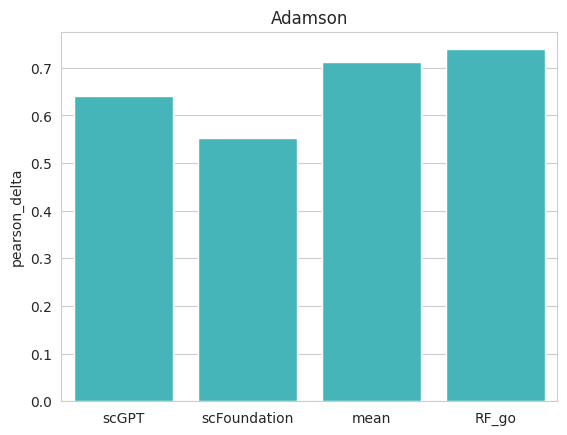

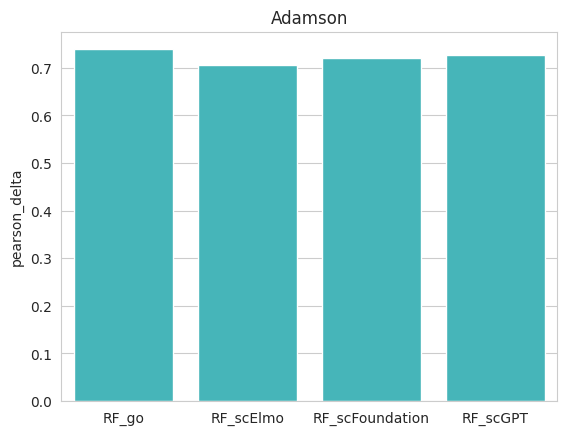

In [7]:
adamson_results = (
    pd.DataFrame
    .from_dict(adamson_results, orient='index')
    .reset_index()
    .rename(columns={"index": "model"})
)
model_eval_plots(adamson_results, "Adamson", Path("../figures/models"))

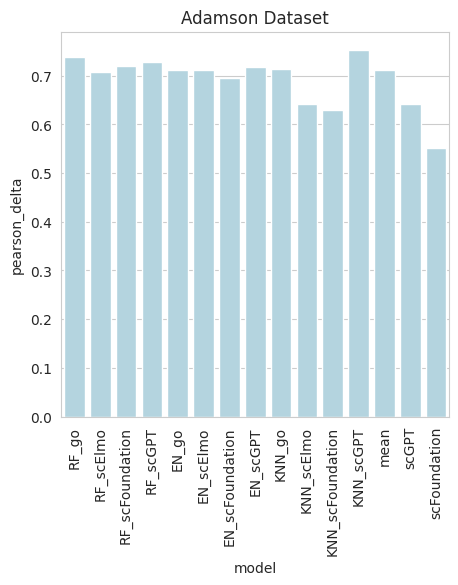

In [8]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(x='model', y='pearson_delta', data=adamson_results, color='lightblue', ax=axs)
axs.set_title("Adamson Dataset")

# rotate x labels by 90
for tick in axs.get_xticklabels():
    tick.set_rotation(90)

## Norman

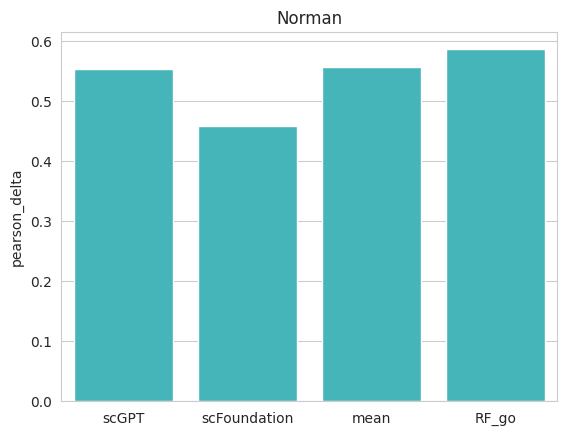

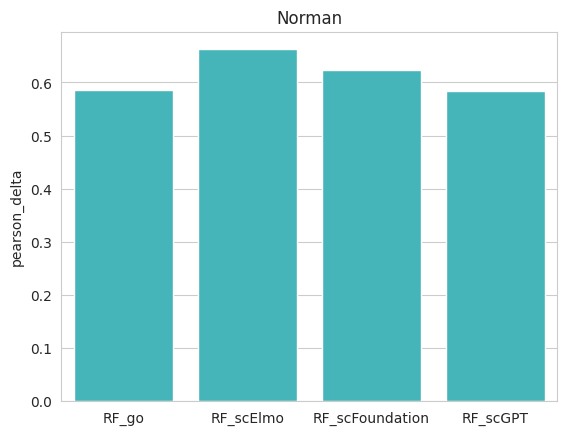

In [9]:
norman_results = pd.DataFrame.from_dict(norman_results, orient='index').reset_index().rename(columns={"index": "model"})

model_eval_plots(norman_results, "Norman", Path("../figures/models"))

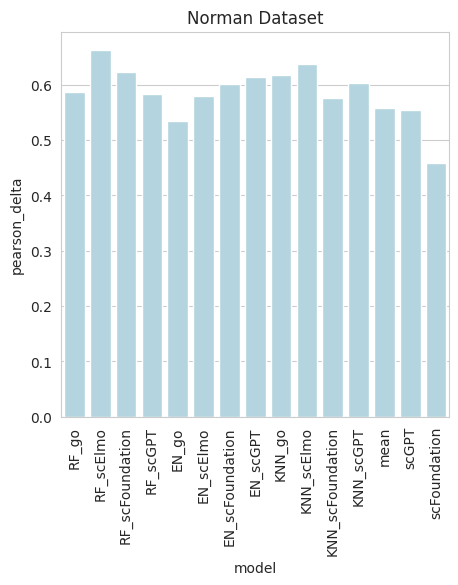

In [10]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(x='model', y='pearson_delta', data=norman_results, color='lightblue', ax=axs)
axs.set_title("Norman Dataset")

# rotate x labels by 90
for tick in axs.get_xticklabels():
    tick.set_rotation(90)

## Replogle

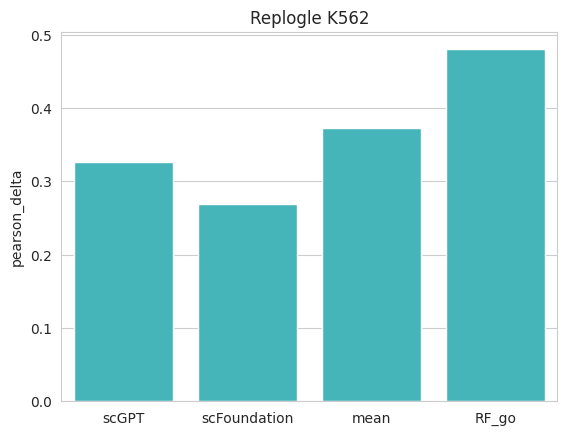

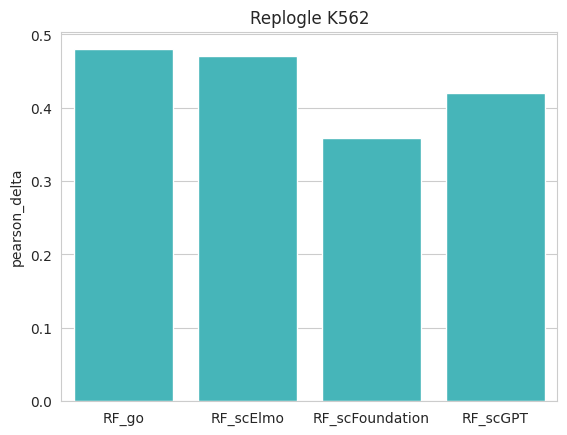

In [11]:
replogle_results = pd.DataFrame.from_dict(replogle_results, orient='index').reset_index().rename(columns={"index": "model"})

model_eval_plots(replogle_results, "Replogle K562", Path("../figures/models"))

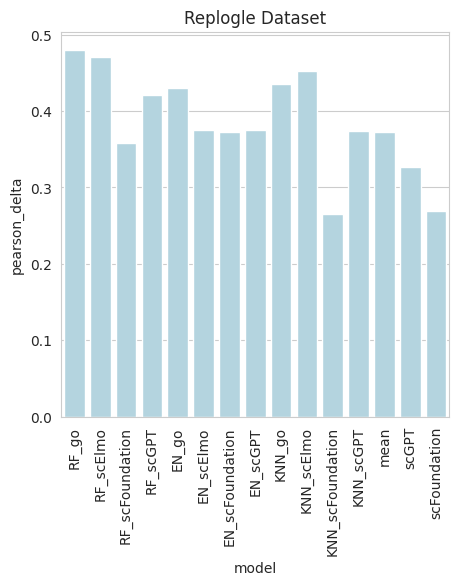

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(x='model', y='pearson_delta', data=replogle_results, color='lightblue', ax=axs)
axs.set_title("Replogle Dataset")

# rotate x labels by 90
for tick in axs.get_xticklabels():
    tick.set_rotation(90)

## Replogle RP1

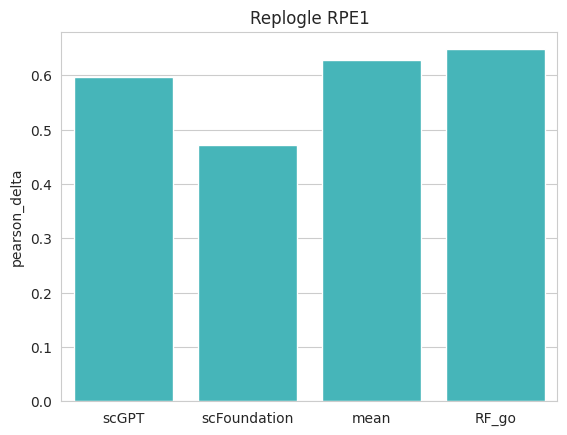

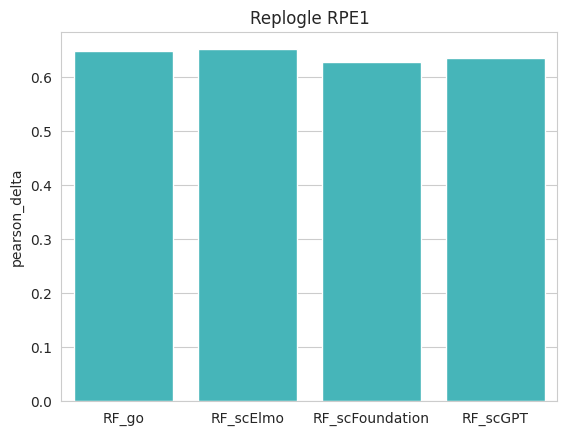

In [13]:
replogle_rp1_results = pd.DataFrame.from_dict(replogle_rp1_results, orient='index').reset_index().rename(columns={"index": "model"})

model_eval_plots(replogle_rp1_results, "Replogle RPE1", Path("../figures/models"))

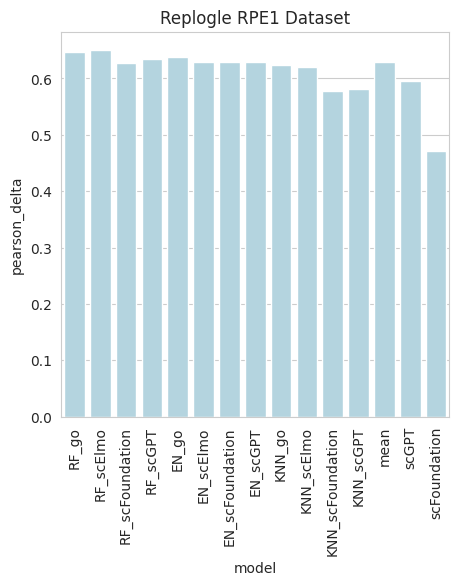

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(x='model', y='pearson_delta', data=replogle_rp1_results, color='lightblue', ax=axs)
axs.set_title("Replogle RPE1 Dataset")

# rotate x labels by 90
for tick in axs.get_xticklabels():
    tick.set_rotation(90)

### Write tables

In [15]:
figure_dir = Path("../figures/models")
adamson_results.to_csv(figure_dir / "adamson_results.csv", index=False)
norman_results.to_csv(figure_dir / "norman_results.csv", index=False)
replogle_results.to_csv(figure_dir / "replogle_k562_results.csv", index=False)
replogle_rp1_results.to_csv(figure_dir / "replogle_rpe1_results.csv", index=False)

## Diversity affects model performence

In [87]:
data_composition = {
    "Adamson": {
        "Median_corr": 0.662,
        "Test-train_corr": 0.654,
    },
    "Norman": {
        "Median_corr": 0.273,
        "Test-train_corr": 0.256,
    },
    "Replogle K562": {
        "Median_corr": 0.117,
        "Test-train_corr": 0.276,
    },
    "Replogle RPE1": {
        "Median_corr": 0.435,
        "Test-train_corr": 0.388,
    },
}

In [88]:
# find model with best pearson_delta
adamson_rf_models = adamson_results[adamson_results['model'].str.contains("RF")]
adamson_best = adamson_rf_models.loc[[adamson_rf_models['pearson_delta'].idxmax()]]


In [89]:
def get_best_model_with_mean(df):
    mean_model = df[df['model'] == 'mean']
    best_rf_model = df[df['model'].str.contains("RF")].sort_values(by='pearson_delta', ascending=False).iloc[[0]]
    return pd.concat([mean_model, best_rf_model]).reset_index(drop=True)[['model', 'pearson_delta']]

In [90]:
name_res_map = {
    "Adamson": adamson_results,
    "Norman": norman_results,
    "Replogle K562": replogle_results,
    "Replogle RPE1": replogle_rp1_results,
}

diversity_model_df = []
for name, res in name_res_map.items():
    _df = get_best_model_with_mean(res)
    _df['dataset'] = name
    diversity_model_df.append(_df)


In [91]:
diversity_model_df = pd.concat(diversity_model_df)
diversity_model_df["model"] = np.where(diversity_model_df["model"] == "mean", "Mean", "Best")

In [92]:
diversity_model_df = diversity_model_df.pivot(index='dataset', columns='model', values='pearson_delta')
diversity_model_df

model,Best,Mean
dataset,,
Adamson,0.738712,0.711148
Norman,0.662807,0.557266
Replogle K562,0.480000,0.372996
Replogle RPE1,0.650609,0.628385


In [93]:
data_composition = pd.DataFrame.from_dict(data_composition, orient='index')

In [94]:
data_composition = data_composition.merge(diversity_model_df, left_index=True, right_index=True)

In [95]:
data_composition["Perf_delta"] = data_composition["Best"] - data_composition["Mean"]
data_composition

,Median_corr,Test-train_corr,Best,Mean,Perf_delta
Adamson,0.662,0.654,0.738712,0.711148,0.027564
Norman,0.273,0.256,0.662807,0.557266,0.105541
Replogle K562,0.117,0.276,0.480000,0.372996,0.107004
Replogle RPE1,0.435,0.388,0.650609,0.628385,0.022224


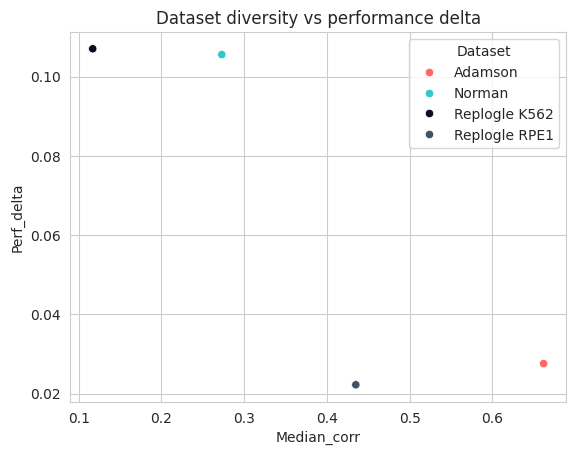

In [98]:
sns.scatterplot(data=data_composition, x='Median_corr', y="Perf_delta", hue=data_composition.index)

# name legend as Dataset
plt.legend(title='Dataset')
plt.title("Dataset diversity vs performance delta")

plt.savefig(figure_dir / "dataset_diversity_vs_performance_delta.png", dpi=300, bbox_inches='tight')
plt.savefig(figure_dir / "dataset_diversity_vs_performance_delta.pdf")